# Import libraries and install packages pydrive and ngrok

In [1]:
! pip install pydrive

In [2]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-06-25 09:30:03--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.152.208.69, 54.156.237.249, 54.164.206.44, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.152.208.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.4’

ngrok-stable-linux- 100%[===================>]   5.11M  --.-KB/s    in 0.1s    

2018-06-25 09:30:03 (46.2 MB/s) - ‘ngrok-stable-linux-amd64.zip.4’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [5]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://d17dd22e.ngrok.io


In [6]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product
from keras.callbacks import TensorBoard


Using TensorFlow backend.


# Define functions

In [0]:
def copy_directory(source_id, local_target):
  try:
    os.makedirs(local_target)
  except: 
    pass
  k = 0
  print('folder id: %s' % (source_id))
  print('downloading to: %s' % (local_target)) 
  file_list = drive.ListFile(
    {'q': "'{source_id}' in parents".format(source_id=source_id)}).GetList()
  for f in file_list:
    if f["title"].startswith("."):
      continue
    fname = os.path.join(local_target, f['title'])
    if f['mimeType'] == 'application/vnd.google-apps.folder':
      copy_directory(f['id'], fname)
    else:
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      k += 1
  print('downloaded files: {}'.format(k))

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(40,40)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        #shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

    if training_data_dir.count('/') > 1:
        #shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [0]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# Connect to Google Drive and load files to local drive

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
training_path = os.path.expanduser('~/data/Training')
testing_path = os.path.expanduser('~/data/Testing')
prediction_path = os.path.expanduser('~/data/Prediction')
try:
  os.makedirs(training_path)
  os.makedirs(testing_path)
  os.makedirs(prediction_path)  
except: pass

In [13]:
copy_directory('1aM5XbStClMulA5CShCD9tfkYqAUjCCpX','~/data/Training')  

folder id: 1aM5XbStClMulA5CShCD9tfkYqAUjCCpX
downloading to: ~/data/Training
folder id: 1mx5TBRm4vVmdOsPQJdq1d5qw9ctWc8B-
downloading to: ~/data/Training/00057
downloaded files: 84
folder id: 1u0tlqDdHvZV1hJl019-XoCG7fFjITus_
downloading to: ~/data/Training/00055
downloaded files: 12
folder id: 1_rXkNqooP8wHa3zPFMUq9vaa3x5xLhov
downloading to: ~/data/Training/00054
downloaded files: 118
folder id: 11cPrN6p9kk7PXqyplN1wEnin1AaE2Y74
downloading to: ~/data/Training/00053
downloaded files: 199
folder id: 1Pr39K2HPRzk6wx9N0WMk7ZB0v2C1dmgD
downloading to: ~/data/Training/00056
downloaded files: 95
folder id: 1C9cWAUvYnClkyWBe7keryVVOjRx_taPu
downloading to: ~/data/Training/00058
downloaded files: 15
folder id: 1K8usvAi5gnwwXn7AZClaBybMOiZ9T5JE
downloading to: ~/data/Training/00052
downloaded files: 27
folder id: 1RWh6iVAHCpE-vR9IBwNO56Fpb_X4M1gr
downloading to: ~/data/Training/00061
downloaded files: 282
folder id: 1TwA3ZnsNIgc_UprcWUS1NyBL0USTP-0N
downloading to: ~/data/Training/00060
downl

downloaded files: 42
folder id: 1-Wg1TxuVje6_f03DpcmjkkbJMtuvwWxq
downloading to: ~/data/Training/00022
downloaded files: 375
folder id: 19vxjagORkKgxAACVFA2Y0aBDcKG_RDbf
downloading to: ~/data/Training/00018
downloaded files: 81
folder id: 1s_7ZRUhTP-h2Slp8CnqIBEEgFnO9kPNb
downloading to: ~/data/Training/00017
downloaded files: 79
folder id: 1I22w9BFMHCL0TrFdAumRTlsKHVSq3LZg
downloading to: ~/data/Training/00016
downloaded files: 9
folder id: 1RVwiH6nEVsdbvLjBRZMF03yil1-bJPNS
downloading to: ~/data/Training/00015
downloaded files: 9
folder id: 1cVlQRTienxYOeL9DgKNPKY3LGku345md
downloading to: ~/data/Training/00009
downloaded files: 18
folder id: 1EpQCq5-o9_NlhTZmEiEzM3xXp4Ao5Sup
downloading to: ~/data/Training/00011
downloaded files: 7
folder id: 1-0IuweoNh2MdQKgUALjmrOyPV9gJpLHD
downloading to: ~/data/Training/00014
downloaded files: 43
folder id: 1YhkzgHy8lK1cjVxpCYPSF7HisuIDJAEe
downloading to: ~/data/Training/00013
downloaded files: 90
folder id: 1BCH2RKrH6EZHMMIDhrx0qwtvGux-Y9Yc


In [14]:
copy_directory('1PVPjRT22MRPHkiyqCdEeKp3OGiaSUk_C','~/data/Testing')  

folder id: 1PVPjRT22MRPHkiyqCdEeKp3OGiaSUk_C
downloading to: ~/data/Testing
folder id: 1MEYyG00CDI2INl84PbecjwpKEyBJvk-P
downloading to: ~/data/Testing/00009
downloaded files: 1
folder id: 1u83OYC8fA72AdijjQ7rd56NZ3EJs-4RK
downloading to: ~/data/Testing/00011
downloaded files: 1
folder id: 1QmaUrXYV-dnc6mXke_0y8i_6_3Jj4Gs_
downloading to: ~/data/Testing/00015
downloaded files: 1
folder id: 1wLAYtt2I5sASij8jVaK0KgAUIw3lxeWh
downloading to: ~/data/Testing/00026
downloaded files: 1
folder id: 1Z7oa58zDlaqyJaGT6kTSzvDUYkd8uKbY
downloading to: ~/data/Testing/00033
downloaded files: 1
folder id: 1ss3yOtwDeRAjRUTCkvG2ezJ9BZsst6eX
downloading to: ~/data/Testing/00036
downloaded files: 1
folder id: 1DPg6teSsVjSfqVUCdEjmECigQqXgRnHW
downloading to: ~/data/Testing/00048
downloaded files: 1
folder id: 1bGhqEefobtfmc-lAG7M_K_IqiCLV2GiH
downloading to: ~/data/Testing/00050
downloaded files: 1
folder id: 15s0tSZor3q04fWyqbVJ695Zlbt0NfpVW
downloading to: ~/data/Testing/00052
downloaded files: 1
folder

downloaded files: 39
folder id: 166vYVpYePC9QWroWB4qwJZOa8ZYhs5IA
downloading to: ~/data/Testing/00016
downloaded files: 12
folder id: 124Pu86vJHDL9BcrLOskskMfKsSKvSI3g
downloading to: ~/data/Testing/00018
downloaded files: 122
folder id: 1TU9XXLHf_Fh7Rm19ywK_KzqZM_gwug9M
downloading to: ~/data/Testing/00020
downloaded files: 3
folder id: 1WxTNnveG6Sfnd6w_e6nSoJmxGU2pQlWt
downloading to: ~/data/Testing/00022
downloaded files: 61
folder id: 1l47aEPL92dJCspUmNei8tD4v4qLQgGgB
downloading to: ~/data/Testing/00012
downloaded files: 3
folder id: 1ueopkcGNWhnL6yy_GTuwidDggIssnayL
downloading to: ~/data/Testing/00019
downloaded files: 163
folder id: 1IwN3THfDTAxjR45HXhDYzLLEOi5s7X5o
downloading to: ~/data/Testing/00017
downloaded files: 183
folder id: 1D15y3A2NDYmUKLwDEdrn6y8RK7_4sqnH
downloading to: ~/data/Testing/00014
downloaded files: 15
folder id: 1iBH6p9XrxyEiVYhVap8NH5XHOFScdWsw
downloading to: ~/data/Testing/00021
downloaded files: 45
folder id: 1hTHDeQwfT5Q4tnzefM8pEx0n_5t9wGg2
downlo

In [15]:
copy_directory('1t7xxFxNW_O2WRYMsVKcxrQ6vYBIMd5yG','~/data/Prediction')  

folder id: 1t7xxFxNW_O2WRYMsVKcxrQ6vYBIMd5yG
downloading to: ~/data/Prediction
downloaded files: 5


# Prepare training, validation and test dataset

In [16]:
split_dataset_into_test_and_train_sets('~/data/Training','~/data/Training_part','~/data/Validation_part',0.4)

Successfully cleaned directory ~/data/Validation_part
Successfully cleaned directory ~/data/Training_part
Training vs Training
00026 vs Training
00034 vs Training
00045 vs Training
00023 vs Training
00010 vs Training
00053 vs Training
00032 vs Training
00057 vs Training
00035 vs Training
00058 vs Training
00022 vs Training
00047 vs Training
00024 vs Training
00030 vs Training
00001 vs Training
00049 vs Training
00007 vs Training
00040 vs Training
00021 vs Training
00000 vs Training
00028 vs Training
00055 vs Training
00029 vs Training
00037 vs Training
00051 vs Training
00039 vs Training
00020 vs Training
00025 vs Training
00059 vs Training
00056 vs Training
00016 vs Training
00041 vs Training
00012 vs Training
00014 vs Training
00009 vs Training
00061 vs Training
00002 vs Training
00008 vs Training
00033 vs Training
00005 vs Training
00013 vs Training
00003 vs Training
00052 vs Training
00042 vs Training
00036 vs Training
00011 vs Training
00017 vs Training
00027 vs Training
00043 vs 

In [17]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
training_set = train_datagen.flow_from_directory('~/data/Training_part', target_size=(64, 64), batch_size=1, class_mode='categorical')
validation_set = train_datagen.flow_from_directory('~/data/Validation_part', target_size=(64, 64), batch_size=1, class_mode='categorical')
test_set = test_datagen.flow_from_directory('~/data/Testing', target_size=(64, 64), batch_size=1, shuffle = False, class_mode='categorical')

Found 2728 images belonging to 62 classes.
Found 1847 images belonging to 62 classes.
Found 2529 images belonging to 62 classes.


# Calculate histograms of datasets

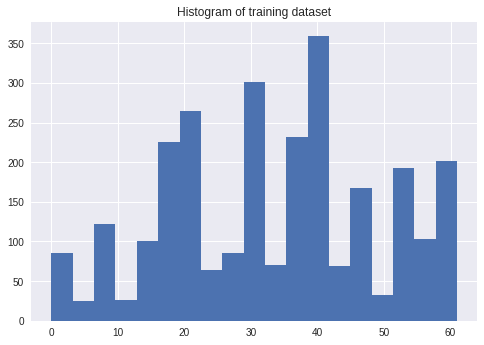

In [18]:
import matplotlib.pyplot as plt
plt.hist(training_set.classes, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of training dataset")
plt.show()

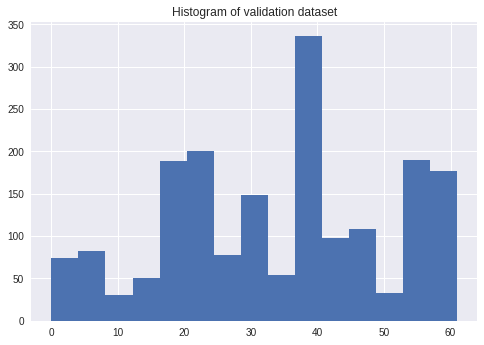

In [19]:
import matplotlib.pyplot as plt
plt.hist(validation_set.classes, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of validation dataset")
plt.show()

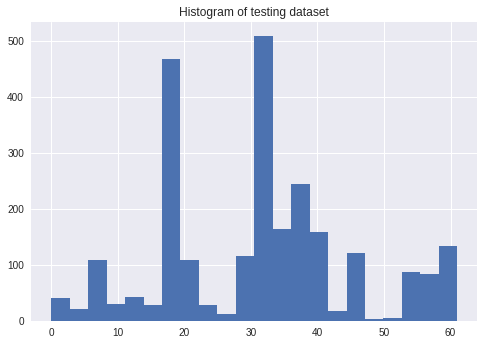

In [20]:
import matplotlib.pyplot as plt
plt.hist(test_set.classes, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of testing dataset")
plt.show()

# Build and train CNN model and connect to TensorBoard, then save model to Google Drive

In [0]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten(input_shape=classifier.output_shape[1:]))
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 62, activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'top_k_categorical_accuracy'])

In [23]:
classifier.summary()
classifier.get_config()
classifier.layers[0].get_config()
classifier.layers[0].input_shape			
classifier.layers[0].output_shape			
classifier.layers[0].get_weights()
np.shape(classifier.layers[0].get_weights()[0])
classifier.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

True

In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=1,
                         write_images=True)

In [0]:
num_epoch = 15

In [26]:
hist = classifier.fit_generator(training_set,steps_per_epoch = 2755, epochs = num_epoch, validation_data = test_set, validation_steps = 1820,callbacks=[tbCallBack])
classifier.save('my_classifier_final_1.h5')

Epoch 1/15
2755/2755 [==============================] - 44s 16ms/step - loss: 2.3959 - acc: 0.4236 - top_k_categorical_accuracy: 0.6886 - val_loss: 1.7074 - val_acc: 0.5396 - val_top_k_categorical_accuracy: 0.8566
Epoch 2/15
 179/2755 [>.............................] - ETA: 32s - loss: 1.4475 - acc: 0.6201 - top_k_categorical_accuracy: 0.8771

2755/2755 [==============================] - 42s 15ms/step - loss: 1.1614 - acc: 0.6995 - top_k_categorical_accuracy: 0.9111 - val_loss: 0.8674 - val_acc: 0.7451 - val_top_k_categorical_accuracy: 0.9555
Epoch 3/15
 380/2755 [===>..........................] - ETA: 30s - loss: 0.8566 - acc: 0.7553 - top_k_categorical_accuracy: 0.9368

2755/2755 [==============================] - 42s 15ms/step - loss: 0.7745 - acc: 0.7909 - top_k_categorical_accuracy: 0.9514 - val_loss: 0.6782 - val_acc: 0.8126 - val_top_k_categorical_accuracy: 0.9692
Epoch 4/15
 418/2755 [===>..........................] - ETA: 29s - loss: 0.6642 - acc: 0.8086 - top_k_categorical_accuracy: 0.9689

2755/2755 [==============================] - 41s 15ms/step - loss: 0.6493 - acc: 0.8211 - top_k_categorical_accuracy: 0.9619 - val_loss: 0.4844 - val_acc: 0.8747 - val_top_k_categorical_accuracy: 0.9709
Epoch 5/15
 475/2755 [====>.........................] - ETA: 28s - loss: 0.5097 - acc: 0.8421 - top_k_categorical_accuracy: 0.9789

2755/2755 [==============================] - 42s 15ms/step - loss: 0.5834 - acc: 0.8377 - top_k_categorical_accuracy: 0.9735 - val_loss: 0.4987 - val_acc: 0.8687 - val_top_k_categorical_accuracy: 0.9654
Epoch 6/15
 488/2755 [====>.........................] - ETA: 28s - loss: 0.3938 - acc: 0.8873 - top_k_categorical_accuracy: 0.9857

2755/2755 [==============================] - 42s 15ms/step - loss: 0.4827 - acc: 0.8646 - top_k_categorical_accuracy: 0.9797 - val_loss: 0.4101 - val_acc: 0.8885 - val_top_k_categorical_accuracy: 0.9824
Epoch 7/15
 480/2755 [====>.........................] - ETA: 29s - loss: 0.4372 - acc: 0.8750 - top_k_categorical_accuracy: 0.9833

2755/2755 [==============================] - 42s 15ms/step - loss: 0.4016 - acc: 0.8868 - top_k_categorical_accuracy: 0.9844 - val_loss: 0.4638 - val_acc: 0.8874 - val_top_k_categorical_accuracy: 0.9857
Epoch 8/15
 470/2755 [====>.........................] - ETA: 29s - loss: 0.4242 - acc: 0.8596 - top_k_categorical_accuracy: 0.9915

2755/2755 [==============================] - 42s 15ms/step - loss: 0.3676 - acc: 0.8849 - top_k_categorical_accuracy: 0.9877 - val_loss: 0.2451 - val_acc: 0.9352 - val_top_k_categorical_accuracy: 0.9951
Epoch 9/15
 489/2755 [====>.........................] - ETA: 29s - loss: 0.4044 - acc: 0.8855 - top_k_categorical_accuracy: 0.9877

2755/2755 [==============================] - 42s 15ms/step - loss: 0.3409 - acc: 0.8962 - top_k_categorical_accuracy: 0.9884 - val_loss: 0.4098 - val_acc: 0.9187 - val_top_k_categorical_accuracy: 0.9896
Epoch 10/15
 483/2755 [====>.........................] - ETA: 29s - loss: 0.4826 - acc: 0.8716 - top_k_categorical_accuracy: 0.9855

2755/2755 [==============================] - 42s 15ms/step - loss: 0.3625 - acc: 0.8976 - top_k_categorical_accuracy: 0.9891 - val_loss: 0.2730 - val_acc: 0.9335 - val_top_k_categorical_accuracy: 0.9896
Epoch 11/15
 498/2755 [====>.........................] - ETA: 28s - loss: 0.3305 - acc: 0.9096 - top_k_categorical_accuracy: 0.9839

2755/2755 [==============================] - 42s 15ms/step - loss: 0.3516 - acc: 0.9064 - top_k_categorical_accuracy: 0.9873 - val_loss: 0.3041 - val_acc: 0.9253 - val_top_k_categorical_accuracy: 0.9907
Epoch 12/15
 488/2755 [====>.........................] - ETA: 28s - loss: 0.2582 - acc: 0.8955 - top_k_categorical_accuracy: 1.0000

2755/2755 [==============================] - 42s 15ms/step - loss: 0.2615 - acc: 0.9209 - top_k_categorical_accuracy: 0.9949 - val_loss: 0.2971 - val_acc: 0.9253 - val_top_k_categorical_accuracy: 0.9934
Epoch 13/15
 472/2755 [====>.........................] - ETA: 28s - loss: 0.2809 - acc: 0.9258 - top_k_categorical_accuracy: 0.9936

2755/2755 [==============================] - 42s 15ms/step - loss: 0.2753 - acc: 0.9194 - top_k_categorical_accuracy: 0.9949 - val_loss: 0.3167 - val_acc: 0.9308 - val_top_k_categorical_accuracy: 0.9929
Epoch 14/15
 461/2755 [====>.........................] - ETA: 29s - loss: 0.2088 - acc: 0.9414 - top_k_categorical_accuracy: 0.9935

2755/2755 [==============================] - 42s 15ms/step - loss: 0.2436 - acc: 0.9321 - top_k_categorical_accuracy: 0.9931 - val_loss: 0.2553 - val_acc: 0.9473 - val_top_k_categorical_accuracy: 0.9912
Epoch 15/15
 487/2755 [====>.........................] - ETA: 28s - loss: 0.1765 - acc: 0.9487 - top_k_categorical_accuracy: 1.0000

2755/2755 [==============================] - 41s 15ms/step - loss: 0.2382 - acc: 0.9368 - top_k_categorical_accuracy: 0.9946 - val_loss: 0.3223 - val_acc: 0.9253 - val_top_k_categorical_accuracy: 0.9929


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
uploaded = drive.CreateFile()
uploaded.SetContentFile('my_classifier_final_1.h5')
uploaded.Upload()

# Calculate basic statistics and evaluate the model

In [0]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
train_acc_top5 = hist.history['top_k_categorical_accuracy']
val_acc_top5 = hist.history['val_top_k_categorical_accuracy']
xc=range(num_epoch)

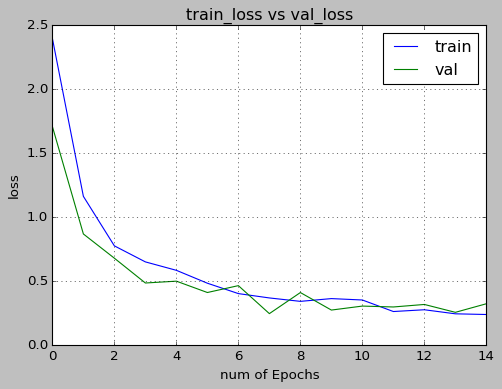

In [39]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

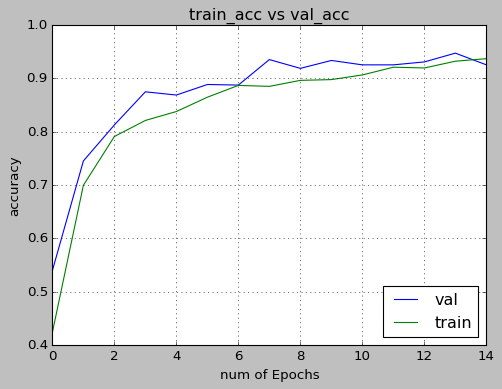

In [45]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,val_acc)
plt.plot(xc,train_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['val','train'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

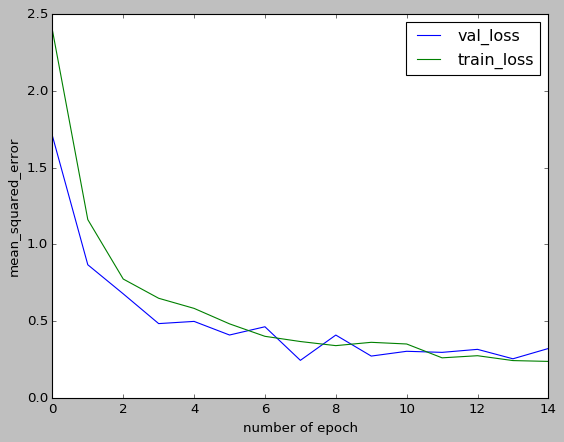

In [42]:
    plt.figure()
    plt.plot(xc, val_loss, label='val_loss')
    plt.plot(xc, train_loss, label='train_loss')
    plt.ylabel("mean_squared_error")
    plt.xlabel("number of epoch")
    plt.legend()
    plt.savefig("Loss_top5.png")

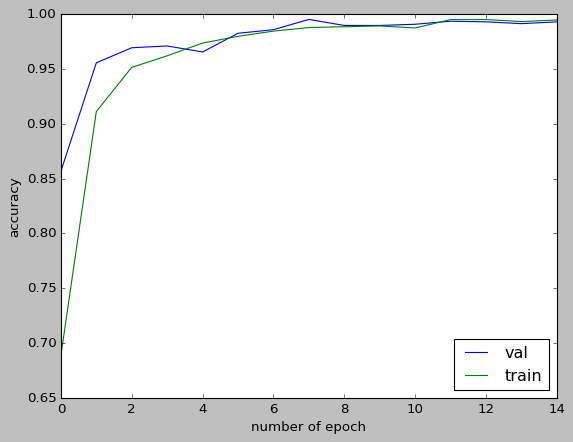

In [43]:
    plt.figure()
    plt.plot(xc, val_acc_top5, label='val')
    plt.plot(xc, train_acc_top5, label='train')
    plt.legend(loc=4)
    plt.ylabel("accuracy")
    plt.xlabel("number of epoch")
    plt.savefig("Accuracy_top5.png")

In [33]:
# Evaluating the model
score = classifier.evaluate_generator(test_set)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.31791333549080697
Test accuracy: 0.9264531435349941


In [0]:
model = load_model('my_classifier_final_1.h5')

# Predict by single image input

In [0]:
labels = ["Uneven road", "Speed bump", "Slippery road", "Dangerous curve to the left", "Dangerous curve to the right", "Double dangerous curve to the left", "Double dangerous curve to the right", "Presence of children", "Bicycle crossing", "Cattle crossing", "Road works ahead", "Traffic signals ahead", "Guarded railroad crossing", "Indefinite danger", "Road narrows", "Road narrows from the left", "Road narrows from the right", "Priority at the next intersection", "Intersection where the priority from the right is applicable", "Yield right of way", "Yield to oncoming traffic", "Stop", "No entry for all drivers", "No bicycles allowed", "Maximum weights allowed (including load)", "No cargo vehicles allowed", "Maximum width allowed", "Maximum height allowed", "No traffic allowed in both directions", "No left turn", "No right turn", "No passing to the left vehicles having more than 2 wheels and horse drawn vehicles", "Maximum speed limit", "Mandatory way for pedestrians and bicycles", "Mandatory direction (straight on)", "Mandatory direction (to the right or to the left)", "Mandatory directions(straight on and to the right)", "Mandatory traffic circle", "Mandatory bicycle path", "Path shared between pedestrians, bicycles and mopeds class A", "No parking", "No waiting or parking", "No parking from the 1 st to the 15th of the month", "No parking from the 16th till the end of the month", "Priority over oncoming traffic", "Parking allowed", "Additional parking sign for handicap only", "Parking exclusively for motorcars", "Parking exclusively for trucks", "Parking exclusively for buses/coaches", "Parking on sidewalk or verge mandatory", "Beginning of a residential area", "End of a residential area", "One way traffic", "Dead end", "End of road works", "Pedestrian crosswalk", "Bicycles and mopeds crossing", "Parking ahead", "Speed bump", "End of priority road", "Priority road"]

In [36]:
test_image = image.load_img('~/data/Prediction/00017_00002.ppm', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
y_pred = np.argmax(result , axis=-1)
print(labels[int(y_pred)])

Uneven road


# Calculate and show confusion matrix

Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.85714286 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.54545455 0.18181818]
 [0.         0.         0.         ... 0.         0.         0.99047619]]


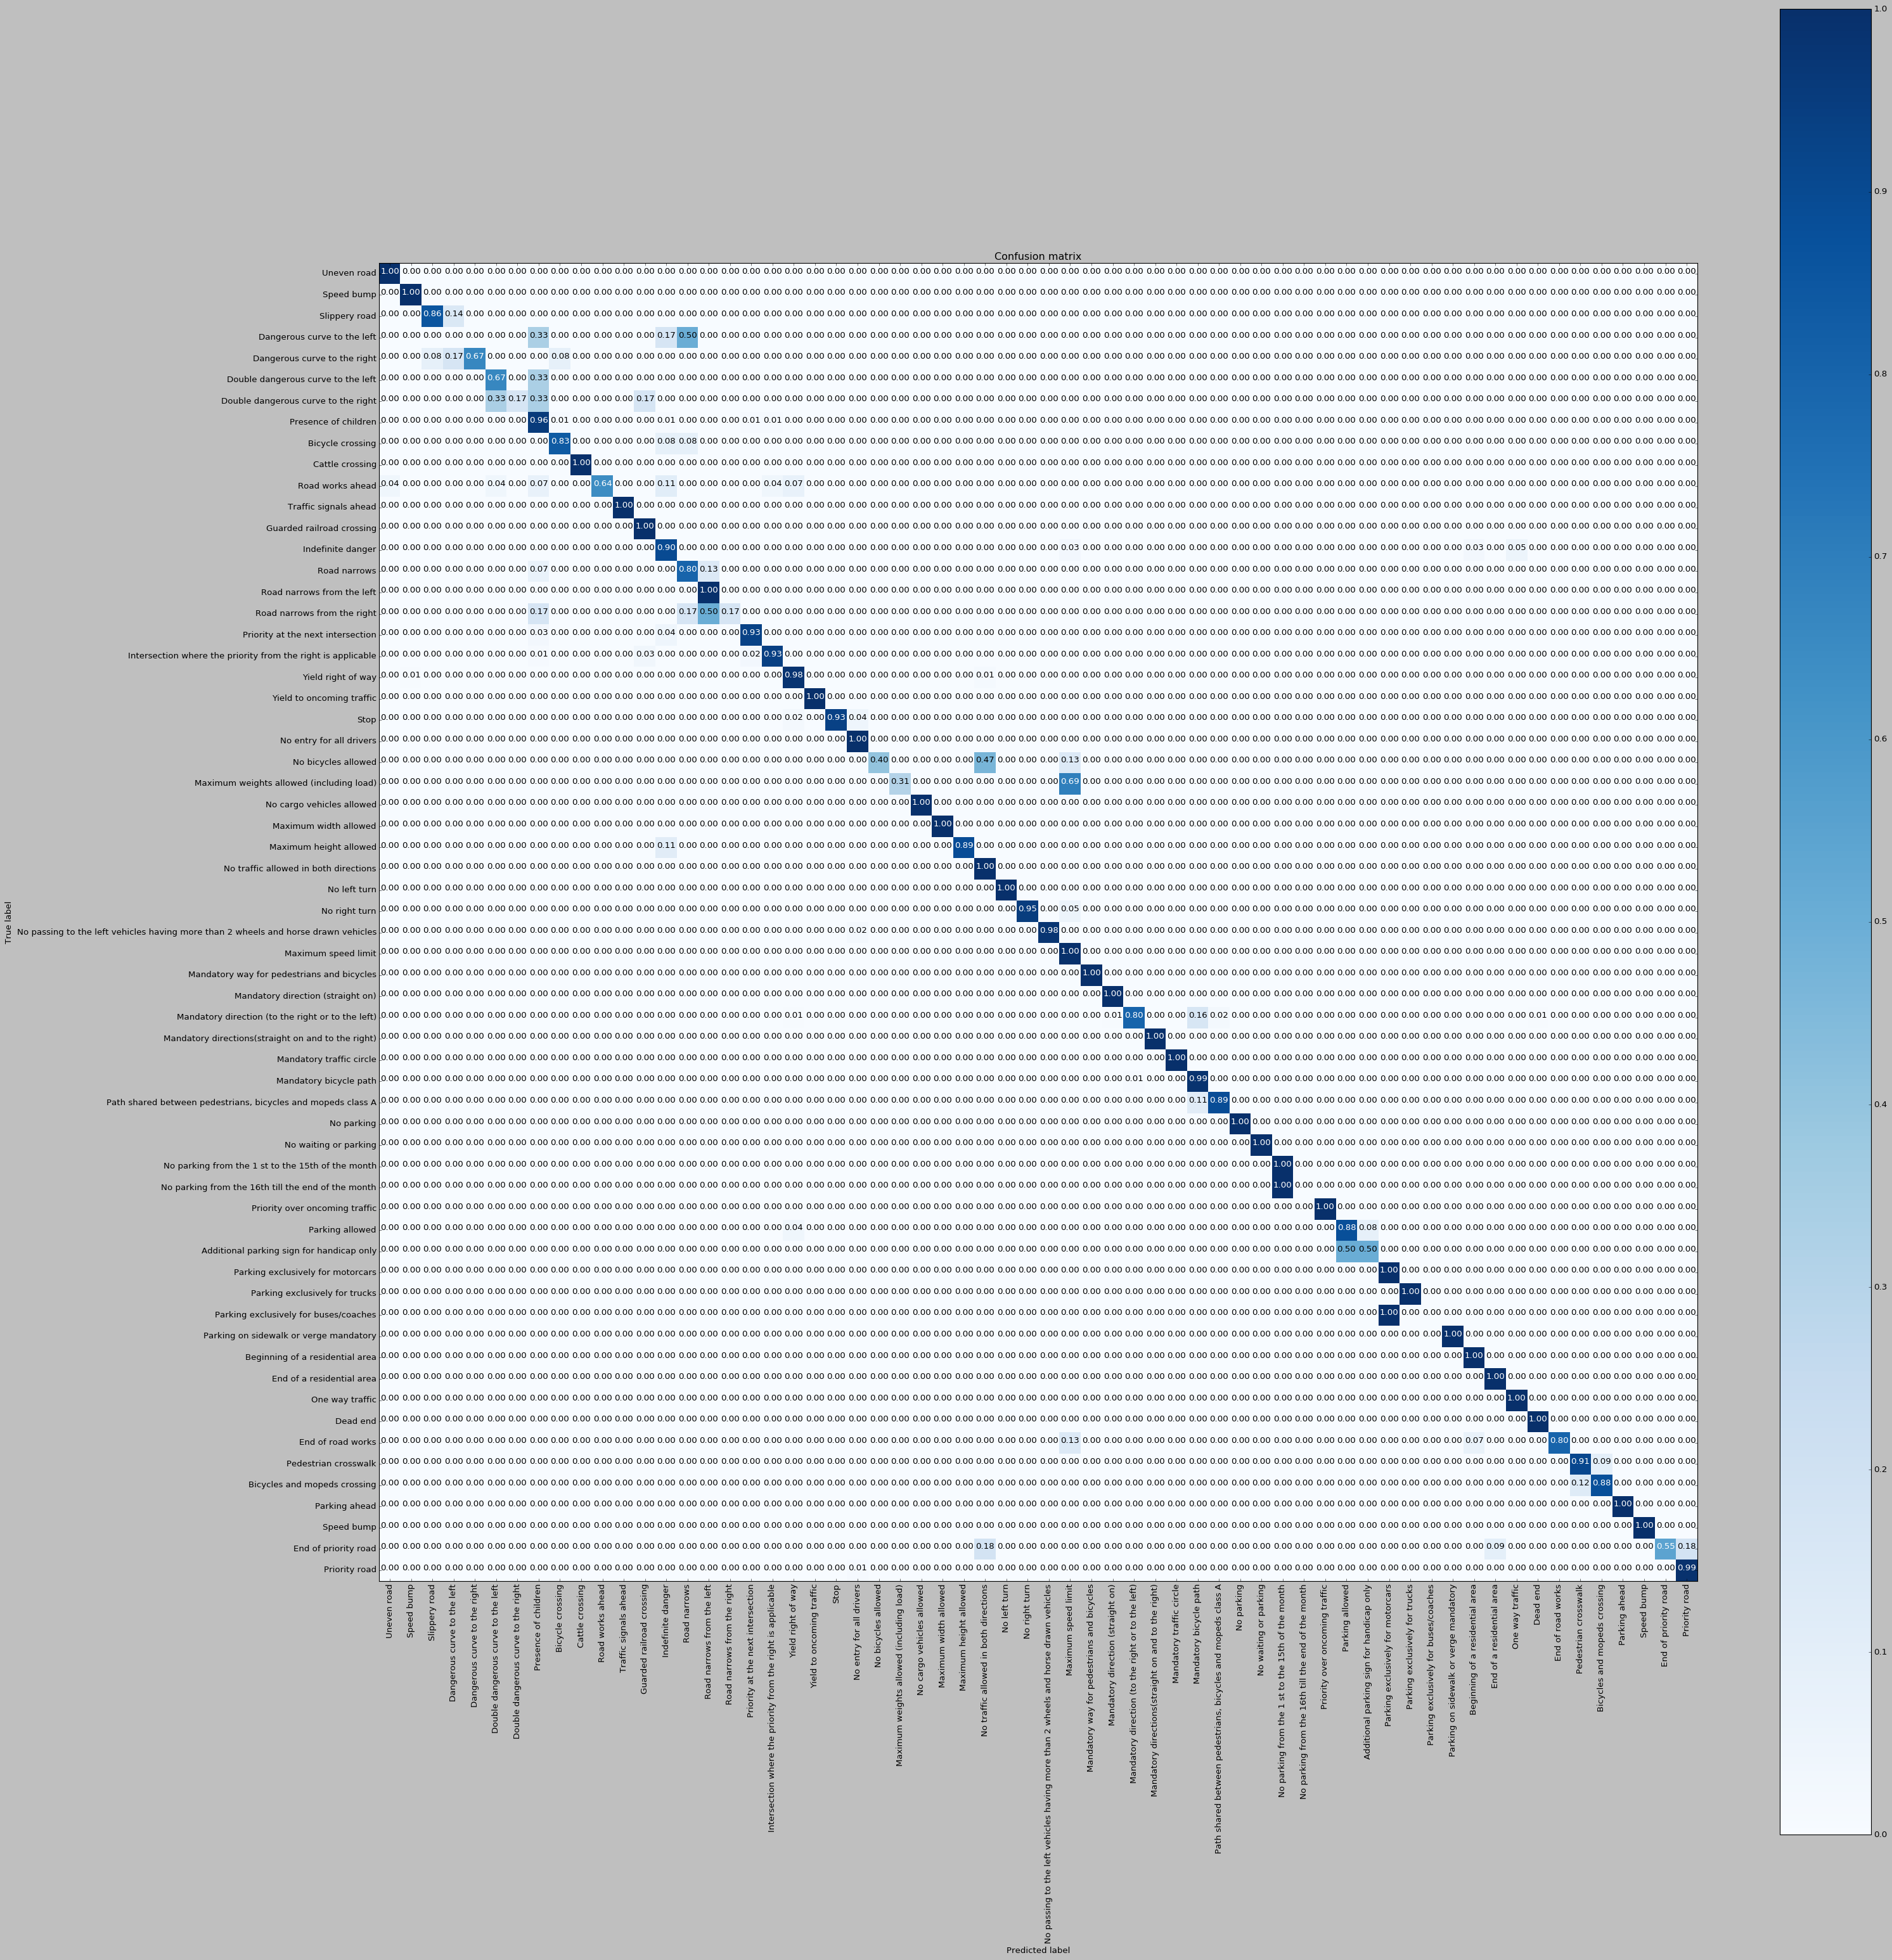

In [37]:
test_set.reset()
probabilities  = model.predict_generator(test_set)
y_pred = np.argmax(probabilities , axis=-1)

cnf_matrix = confusion_matrix(test_set.classes, y_pred)
plot_confusion_matrix(cnf_matrix, labels, True)